In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import torch
import torch.nn as nn
import torch.utils.data as tdata
from em import em_gaussian_mixture
from old_faithful import get_old_faithful_data

from vaes_ptorch import VAE, GaussianMLP, TrainArgs, train
from vaes_ptorch.args import DivAnnealing

In [2]:
save_path = os.path.expanduser("~/vaes_ptorch/data")
er, waits = get_old_faithful_data(save=True, save_dir=save_path)

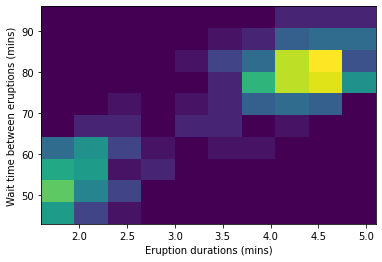

In [3]:
plt.hist2d(er, waits, alpha=1.0)
plt.xlabel("Eruption durations (mins)")
plt.ylabel("Wait time between eruptions (mins)");

(272, 2)

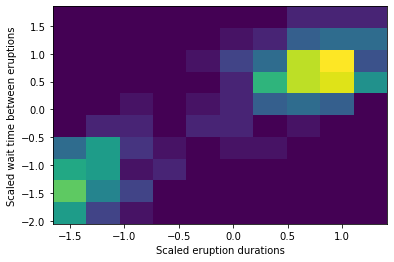

In [33]:
def scale_data(data):  # of shape n, p
    mean_, std_ = data.mean(0), data.std(0)
    return (data - mean_) / std_, (mean_, std_)


data = np.concatenate([er.reshape(-1, 1), waits.reshape(-1, 1)], 1)
data, _ = scale_data(data)
plt.hist2d(data[:, 0], data[:, 1], alpha=1.0)
plt.xlabel("Scaled eruption durations")
plt.ylabel("Scaled wait time between eruptions")
data.shape

In [34]:
theta = em_gaussian_mixture(data, 2, 1000)
theta

Theta(mu=[array([0.7038525 , 0.66846596]), array([-1.27396762, -1.20991826])], sigma=[array([[0.13095257, 0.06084201],
       [0.06084201, 0.19575032]]), array([[0.05329039, 0.02814822],
       [0.02814822, 0.18299437]])], gamma=array([0.64412714, 0.35587286]))

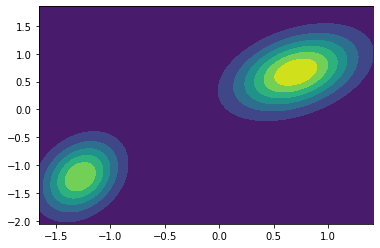

In [35]:
x = np.linspace(data[:, 0].min(), data[:, 0].max(), num=100)
y = np.linspace(data[:, 1].min(), data[:, 1].max(), num=100)
X, Y = np.meshgrid(x, y)

XY = np.concatenate([X[:, :, np.newaxis], Y[:, :, np.newaxis]], axis=-1)

pdfs = (
    sts.multivariate_normal.pdf(XY, theta.mu[0], theta.sigma[0])
    * theta.gamma[0]
    + sts.multivariate_normal.pdf(XY, theta.mu[1], theta.sigma[1])
    * theta.gamma[1]
)

plt.contourf(X, Y, pdfs)

In [112]:
data_dim = 2
latent_dim = 1

h_size = 128
h_layers = 5

lr = 1e-2
batch_size = 256
num_epochs = 300

print_every = 100

info_vae = True
# info_vae = False
start_scale = 0.05
end_scale = 0.05
# start_scale = 0.005
# end_scale = 0.005
start_epochs = 0
linear_epochs = 0

In [113]:
dataset = tdata.TensorDataset(torch.from_numpy(data).float())
dataloader = tdata.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True
)

In [114]:
encoder = GaussianMLP(
    in_dim=data_dim, h_dims=[h_size] * h_layers, out_dim=latent_dim
)
decoder = GaussianMLP(
    in_dim=latent_dim, h_dims=[h_size] * h_layers, out_dim=data_dim
)
vae = VAE(encoder=encoder, decoder=decoder)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)
train_args = TrainArgs(
    info_vae=info_vae,
    num_epochs=num_epochs,
    div_annealing=DivAnnealing(
        start_epochs=start_epochs,
        linear_epochs=linear_epochs,
        start_scale=start_scale,
        end_scale=end_scale,
    ),
    print_every=print_every,
    smoothing=0.9,
)

In [115]:
train(data=dataloader, vae=vae, optimizer=optimizer, args=train_args)

Step: 0 | Loss: 0.49448 | Div scale: 0.050
NLL: 0.49442 | MMD-div: 0.00109
Step: 100 | Loss: 0.03067 | Div scale: 0.050
NLL: 0.02473 | MMD-div: 0.03602
Step: 200 | Loss: 0.02367 | Div scale: 0.050
NLL: 0.02141 | MMD-div: 0.02296
Step: 300 | Loss: 0.02823 | Div scale: 0.050
NLL: 0.02261 | MMD-div: 0.02136
Step: 400 | Loss: 0.02207 | Div scale: 0.050
NLL: 0.01996 | MMD-div: 0.00224
Step: 500 | Loss: 0.02392 | Div scale: 0.050
NLL: 0.02215 | MMD-div: 0.00335


In [116]:
def plot_pdf_2d(xs, ys, zs, conditional_dist):
    mu, var = conditional_dist(zs)
    mu, var = mu.detach().numpy(), var.detach().numpy()
    X, Y = np.meshgrid(xs, ys)
    XY = np.concatenate([X[:, :, np.newaxis], Y[:, :, np.newaxis]], axis=-1)

    pdfs = np.zeros_like(X)
    for ix in range(mu.shape[0]):
        pdf_ix = sts.multivariate_normal.pdf(XY, mu[ix], np.sqrt(var[ix]))
        pdfs += pdf_ix
    pdfs /= mu.shape[0]
    plt.contourf(X, Y, pdfs)


n_monte_carlo_samples = 1000

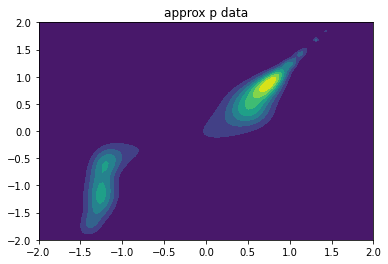

In [117]:
x_grid = np.linspace(-2.0, 2.0, num=100)
y_grid = np.linspace(-2.0, 2.0, num=100)
z_samples = torch.randn((n_monte_carlo_samples, 1))

vae.eval()
with torch.no_grad():
    plt.figure()
    plot_pdf_2d(x_grid, y_grid, z_samples, vae.decoder)
    plt.title("approx p data")
    plt.show()
    plt.close()